# A Big Big-Five Personality Factors Example

We'll begin by downloading and pre-processing the data set, which consists of over 1 million people's responses to 50 Big 5 items (10 items/factor, 5 categories/item).

After some basic pre-processing, we cut the data down to around 630K people.

In [1]:
import os
import urllib.request
import shutil
import pandas as pd

from utils import *
from figures import *

manual_seed(123) # set seed for reproducibility

# Download data.
filepath = "./data/IPIP-FFM-data-8Nov2018/data-final.csv"
if not os.path.exists(filepath):
    os.makedirs(os.path.dirname("./data/"), exist_ok=True)
    urllib.request.urlretrieve("https://openpsychometrics.org/_rawdata/IPIP-FFM-data-8Nov2018.zip",
                               "./data/ipip-ffm.zip")
    shutil.unpack_archive("./data/ipip-ffm.zip", "./data/")

# Pre-processing.
df = pd.read_csv(filepath, sep = "\t", header = 0)
df = df[df["IPC"] == 1] # Drop multiple submissions from same IP address
df.iloc[:, :100] = df.iloc[:, :100].dropna() # Drop NaNs
df = df[df.iloc[:, 0:50].sum(1) > 0] # Drop all missing responses
rc_items = ["EXT2", "EXT4", "EXT6", "EXT8", "EXT10", "AGR1", "AGR3", "AGR5", "AGR7",
            "CSN2", "CSN4", "CSN6", "CSN8", "EST2", "EST4", "OPN2", "OPN4", "OPN6"]
df[rc_items] = ((1 - df[rc_items] / 5) * 5 + 1).mask(lambda col: col == 6, 0) # Fix reverse-coded items
Y = torch.from_numpy(df.iloc[:, :50].to_numpy()) - 1 # item responses
T = torch.from_numpy(df.iloc[:, 50:100].to_numpy()) / 1000 # response times in seconds

missing_mask = 1 * (Y != -1)
Y[Y == -1] = 0
T[T == 0] = 1e-7 # set zero response times (which indicate missingness) to a small value

keeps = ((T < 0).sum(dim = 1) == 0) & ((T > 100).sum(dim = 1) == 0) # drop negative or too long response times
Y, T, missing_mask = Y[keeps], T[keeps], missing_mask[keeps]

print(Y.shape)

n_items = Y.shape[1]

torch.Size([629984, 50])


## Exploratory Item Factor Analysis

We'll first conduct exploratory item factor analysis (IFA).

A typical goal in this context is to determine the number of latent factors underlying the data. We can do this using a log-likelihood (LL) scree plot approach where we fit a number of models with different latent dimensions and estimate the LL on a held-out data set for each dimension. We then plot these LLs and pick the latent dimension corresponding to an "elbow" in the plot.


Latent size =  3

Fitting started
Epoch =       0 Iter. =  18401   Current mean loss = 66.03   Intervals no change = 100
Fitting ended in  66.75  seconds

Computing approx. LL
Approx. LL computed in 16.51 seconds

Latent size =  4

Fitting started
Epoch =       0 Iter. =  17201   Current mean loss = 64.91   Intervals no change = 100
Fitting ended in  62.81  seconds

Computing approx. LL
Approx. LL computed in 17.18 seconds

Latent size =  5

Fitting started
Epoch =       0 Iter. =  16201   Current mean loss = 63.90   Intervals no change = 100
Fitting ended in  60.6  seconds

Computing approx. LL
Approx. LL computed in 20.06 seconds

Latent size =  6

Fitting started
Epoch =       1 Iter. =  21501   Current mean loss = 63.48   Intervals no change = 100
Fitting ended in  76.18  seconds

Computing approx. LL
Approx. LL computed in 20.53 seconds

Latent size =  7

Fitting started
Epoch =       1 Iter. =  23801   Current mean loss = 63.40   Intervals no change = 100
Fitting ended in  87.35

/Users/gateslab/school/code/DeepIRTools/figures.py:90: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


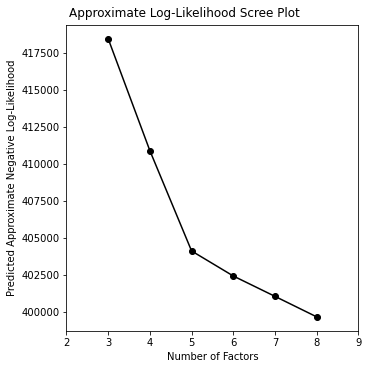

In [2]:
# This will take a few minutes to run.
ll_list = screeplot(latent_sizes = [int(i + 1) for i in range(2, 8)],
                    data = Y,
                    model_type = "grm",
                    test_size = 0.01,
                    inference_net_sizes_list = [[n_items, 100]] * 10,
                    learning_rates = [5e-3] * 10,
                    missing_mask = missing_mask,
                    device = "cpu",                  
                    iw_samples_fit = 5,
                    iw_samples_ll = 500,
                    n_cats = [5] * n_items,
                   )

Another goal in the exploratory context is to uncover the factor loadings structure.

Since we found an "elbow" at 5 latent factors, we fit a 5-factor IFA model with unconstrained loadings and standard normal factors. We then use Geomin oblique rotation from the FactorAnalyzer package to produce rotated loadings, which have a clear simple structure.


Fitting started
Epoch =       0 Iter. =  13801   Current mean loss = 63.73   Intervals no change = 100
Fitting ended in  51.88  seconds


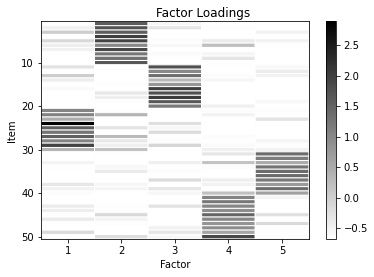

In [3]:
from factor_analyzer import Rotator

model = ImportanceWeightedEstimator(learning_rate = 5e-3,
                                    device = "cpu",
                                    model_type = "grm",
                                    log_interval = 100,
                                    inference_net_sizes = [n_items, 100],
                                    latent_size = 5,
                                    n_cats = [5] * n_items,
                                   )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

rotator = Rotator(method = "geomin_obl")
rot_loadings = rotator.fit_transform(model.loadings)
loadings_heatmap(rot_loadings)

## Confirmatory Item Factor Analysis

In the confirmatory IFA setting, researchers have *a priori* theories about the loadings structure which they want to test for goodness-of-fit.

There are several ways to implement these constraints. One is to use a binary matrix *Q* whose elements are zero if the corresponding loading is set to zero and one otherwise.

We demonstrate this by imposing simple stucture on the loadings matrix using *Q* below. We also estimate the correlations between the latent factors.

In [4]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5)

model = ImportanceWeightedEstimator(learning_rate = 5e-3,
                                    device = "cpu",
                                    model_type = "grm",
                                    log_interval = 100,
                                    Q = Q,
                                    inference_net_sizes = [n_items, 100],
                                    latent_size = 5,
                                    n_cats = [5] * n_items,
                                    correlated_factors = [0, 1, 2, 3, 4],
                                   )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

print("\nLoadings\n\n", np.around(model.loadings.numpy(), 2))
print("\nFactor correlations\n\n", np.around(model.cov.numpy(), 2))


Fitting started
Epoch =       0 Iter. =  14301   Current mean loss = 64.88   Intervals no change = 100
Fitting ended in  77.94  seconds

Loadings

 [[1.88 0.   0.   0.   0.  ]
 [1.98 0.   0.   0.   0.  ]
 [1.91 0.   0.   0.   0.  ]
 [2.27 0.   0.   0.   0.  ]
 [2.35 0.   0.   0.   0.  ]
 [1.45 0.   0.   0.   0.  ]
 [2.23 0.   0.   0.   0.  ]
 [1.34 0.   0.   0.   0.  ]
 [1.46 0.   0.   0.   0.  ]
 [2.11 0.   0.   0.   0.  ]
 [0.   1.92 0.   0.   0.  ]
 [0.   1.34 0.   0.   0.  ]
 [0.   1.51 0.   0.   0.  ]
 [0.   1.04 0.   0.   0.  ]
 [0.   1.2  0.   0.   0.  ]
 [0.   2.2  0.   0.   0.  ]
 [0.   2.22 0.   0.   0.  ]
 [0.   2.48 0.   0.   0.  ]
 [0.   1.89 0.   0.   0.  ]
 [0.   1.75 0.   0.   0.  ]
 [0.   0.   1.29 0.   0.  ]
 [0.   0.   1.54 0.   0.  ]
 [0.   0.   0.74 0.   0.  ]
 [0.   0.   2.59 0.   0.  ]
 [0.   0.   1.92 0.   0.  ]
 [0.   0.   1.38 0.   0.  ]
 [0.   0.   1.9  0.   0.  ]
 [0.   0.   1.54 0.   0.  ]
 [0.   0.   2.08 0.   0.  ]
 [0.   0.   1.01 0.   0.  ]
 [0.   0.  

We can implement a wider range of confirmatory IFA models using linear constraints encoded in a matrix *A* and a vector *b*. We implement a similar model to the one fitted above, except the first loading on each factor is constrained to 1 and the factor variances are freely estimated.

In [5]:
constraint_ls = ([torch.zeros(1), torch.eye(9), torch.zeros([n_items, n_items]),
                  torch.zeros(1), torch.eye(9), torch.zeros([n_items, n_items]),
                  torch.zeros(1), torch.eye(9), torch.zeros([n_items, n_items]),
                  torch.zeros(1), torch.eye(9), torch.zeros([n_items, n_items]),
                  torch.zeros(1), torch.eye(9)])
A = torch.block_diag(*constraint_ls)
b = torch.cat(([torch.ones(1), torch.zeros([9 + n_items]),
                torch.ones(1), torch.zeros([9 + n_items]),
                torch.ones(1), torch.zeros([9 + n_items]),
                torch.ones(1), torch.zeros([9 + n_items]),
                torch.ones(1), torch.zeros([9])]), dim=0)

model = ImportanceWeightedEstimator(learning_rate = 5e-3,
                                    device = "cpu",
                                    model_type = "grm",
                                    log_interval = 100,
                                    A = A,
                                    b = b,
                                    inference_net_sizes = [n_items, 100],
                                    latent_size = 5,
                                    n_cats = [5] * n_items,
                                    fixed_variances = False,
                                    correlated_factors = [0, 1, 2, 3, 4],
                                   )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

print("\nLoadings\n\n", np.around(model.loadings.numpy(), 2))
print("\nFactor covariances\n\n", np.around(model.cov.numpy(), 2))


Fitting started
Epoch =       0 Iter. =  12901   Current mean loss = 65.12   Intervals no change = 100
Fitting ended in  75.5  seconds

Loadings

 [[1.   0.   0.   0.   0.  ]
 [1.07 0.   0.   0.   0.  ]
 [1.05 0.   0.   0.   0.  ]
 [1.24 0.   0.   0.   0.  ]
 [1.31 0.   0.   0.   0.  ]
 [0.79 0.   0.   0.   0.  ]
 [1.22 0.   0.   0.   0.  ]
 [0.77 0.   0.   0.   0.  ]
 [0.85 0.   0.   0.   0.  ]
 [1.16 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.68 0.   0.   0.  ]
 [0.   0.74 0.   0.   0.  ]
 [0.   0.5  0.   0.   0.  ]
 [0.   0.63 0.   0.   0.  ]
 [0.   1.19 0.   0.   0.  ]
 [0.   1.17 0.   0.   0.  ]
 [0.   1.3  0.   0.   0.  ]
 [0.   0.99 0.   0.   0.  ]
 [0.   0.87 0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   1.2  0.   0.  ]
 [0.   0.   0.55 0.   0.  ]
 [0.   0.   1.98 0.   0.  ]
 [0.   0.   1.48 0.   0.  ]
 [0.   0.   1.01 0.   0.  ]
 [0.   0.   1.48 0.   0.  ]
 [0.   0.   1.11 0.   0.  ]
 [0.   0.   1.6  0.   0.  ]
 [0.   0.   0.81 0.   0.  ]
 [0.   0.   

Next, let's fit the generalized partial credit model to the Big Five data using the *Q* matrix approach.

In [6]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5)

model = ImportanceWeightedEstimator(learning_rate = 5e-3,
                                    device = "cpu",
                                    model_type = "gpcm",
                                    log_interval = 100,
                                    Q = Q,
                                    inference_net_sizes = [n_items, 100],
                                    latent_size = 5,
                                    n_cats = [5] * n_items,
                                    correlated_factors = [0, 1, 2, 3, 4],
                                   )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

print("\nLoadings\n\n", np.around(model.loadings.numpy(), 2))
print("\nFactor correlations\n\n", np.around(model.cov.numpy(), 2))


Fitting started
Epoch =       1 Iter. =  35601   Current mean loss = 65.27   Intervals no change = 100
Fitting ended in  201.65  seconds

Loadings

 [[1.05 0.   0.   0.   0.  ]
 [1.13 0.   0.   0.   0.  ]
 [1.19 0.   0.   0.   0.  ]
 [1.45 0.   0.   0.   0.  ]
 [1.58 0.   0.   0.   0.  ]
 [0.78 0.   0.   0.   0.  ]
 [1.22 0.   0.   0.   0.  ]
 [0.66 0.   0.   0.   0.  ]
 [0.76 0.   0.   0.   0.  ]
 [1.23 0.   0.   0.   0.  ]
 [0.   1.09 0.   0.   0.  ]
 [0.   0.69 0.   0.   0.  ]
 [0.   0.85 0.   0.   0.  ]
 [0.   0.46 0.   0.   0.  ]
 [0.   0.55 0.   0.   0.  ]
 [0.   1.28 0.   0.   0.  ]
 [0.   1.33 0.   0.   0.  ]
 [0.   1.59 0.   0.   0.  ]
 [0.   1.01 0.   0.   0.  ]
 [0.   0.92 0.   0.   0.  ]
 [0.   0.   0.58 0.   0.  ]
 [0.   0.   0.91 0.   0.  ]
 [0.   0.   0.32 0.   0.  ]
 [0.   0.   1.91 0.   0.  ]
 [0.   0.   1.22 0.   0.  ]
 [0.   0.   0.76 0.   0.  ]
 [0.   0.   1.22 0.   0.  ]
 [0.   0.   0.89 0.   0.  ]
 [0.   0.   1.34 0.   0.  ]
 [0.   0.   0.58 0.   0.  ]
 [0.   0. 

We can also fit a classic linear factor model with the *Q* matrix approach.

In [7]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5)

model = ImportanceWeightedEstimator(learning_rate = 5e-3,
                                    device = "cpu",
                                    model_type = "normal",
                                    log_interval = 100,
                                    Q = Q,
                                    inference_net_sizes = [n_items, 100],
                                    latent_size = 5,
                                    n_items = n_items,
                                    correlated_factors = [0, 1, 2, 3, 4],
                                   )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

print("\nLoadings\n\n", np.around(model.loadings.numpy(), 2))
print("\nFactor correlations\n\n", np.around(model.cov.numpy(), 2))


Fitting started
Epoch =       0 Iter. =  17701   Current mean loss = 71.99   Intervals no change = 100
Fitting ended in  76.48  seconds

Loadings

 [[0.85 0.   0.   0.   0.  ]
 [0.9  0.   0.   0.   0.  ]
 [0.83 0.   0.   0.   0.  ]
 [0.91 0.   0.   0.   0.  ]
 [0.95 0.   0.   0.   0.  ]
 [0.69 0.   0.   0.   0.  ]
 [1.03 0.   0.   0.   0.  ]
 [0.69 0.   0.   0.   0.  ]
 [0.82 0.   0.   0.   0.  ]
 [0.91 0.   0.   0.   0.  ]
 [0.   0.9  0.   0.   0.  ]
 [0.   0.67 0.   0.   0.  ]
 [0.   0.69 0.   0.   0.  ]
 [0.   0.52 0.   0.   0.  ]
 [0.   0.62 0.   0.   0.  ]
 [0.   0.95 0.   0.   0.  ]
 [0.   0.97 0.   0.   0.  ]
 [0.   1.05 0.   0.   0.  ]
 [0.   0.87 0.   0.   0.  ]
 [0.   0.87 0.   0.   0.  ]
 [0.   0.   0.66 0.   0.  ]
 [0.   0.   0.67 0.   0.  ]
 [0.   0.   0.46 0.   0.  ]
 [0.   0.   0.85 0.   0.  ]
 [0.   0.   0.8  0.   0.  ]
 [0.   0.   0.72 0.   0.  ]
 [0.   0.   0.78 0.   0.  ]
 [0.   0.   0.62 0.   0.  ]
 [0.   0.   0.8  0.   0.  ]
 [0.   0.   0.47 0.   0.  ]
 [0.   0.  

It's sometimes of interest to model response times (which are strictly positive) using a log-normal measurement model. We assume that a single standard normally distributed "speed" latent variable gives rise to the response times. In this setting, the intercepts and residual variances are of interest; loadings are typically constrained to one.

It's worth noting that fitting can be numerically unstable when the response times are too large. To improve stability, we've dropped individuals who took more than 100 seconds to respond to any questions.

In [8]:
A = torch.zeros([n_items, n_items])
b = torch.ones(n_items)

model = ImportanceWeightedEstimator(learning_rate = 1e-3,
                                    device = "cpu",
                                    model_type = "lognormal",
                                    log_interval = 100,
                                    A = A,
                                    b = b,
                                    inference_net_sizes = [n_items, 100],
                                    latent_size = 1,
                                    n_items = n_items,
                                   )
model.fit(T, missing_mask=missing_mask, iw_samples=5)

print("\nIntercepts\n\n", np.around(model.intercepts.numpy(), 2))
print("\nResidual variances\n\n", np.around(model.residual_variances.numpy(), 2))


Fitting started
Epoch =       1 Iter. =  21901   Current mean loss = 137.95   Intervals no change = 100
Fitting ended in  53.63  seconds

Intercepts

 [1.72 0.92 0.97 0.93 0.76 0.84 1.11 0.96 0.98 0.85 0.85 0.91 0.75 0.95
 0.95 0.78 0.84 0.79 0.73 0.66 1.17 0.81 0.88 0.84 1.09 0.69 1.   0.99
 0.86 0.91 0.86 1.12 0.86 0.9  0.96 1.12 0.75 1.11 0.75 1.06 0.74 1.14
 0.69 1.01 0.72 0.87 0.82 0.78 0.86 0.5 ]

Residual variances

 [1.25 1.26 1.14 1.17 1.49 1.02 1.24 1.01 1.1  1.03 1.46 1.57 1.04 1.6
 1.03 1.56 1.02 1.15 1.05 1.19 1.28 1.59 1.01 1.25 1.08 1.51 1.03 1.31
 0.99 1.25 1.85 1.26 1.14 1.15 1.26 1.06 1.14 1.35 1.2  1.38 1.56 1.17
 1.32 1.12 1.22 1.26 1.29 1.23 1.17 1.13]
